# TKT4108 Structural dynamics 2

## Solution exercise 5

**Main topics:** Monte Carlo simulation of time series, auto and cross-correlation, auto and cross-spectral density

**References:** Newland Chapter 4-5




### Problem 1: Simulation of stochastic time series


**a)**

The frequency spacing will be $\Delta \omega=\dfrac{2 \pi}{T}=3.49\cdot 10^{-3}$.


domega is 0.003490658503988659


C:\Users\oyvinpet\AppData\Local\Temp\ipykernel_8636\575607276.py:26: RuntimeWarning: invalid value encountered in divide
  S=(I*U)**2*A*omegaz/(omega*(1+1.5*A*omegaz)**(5/3))


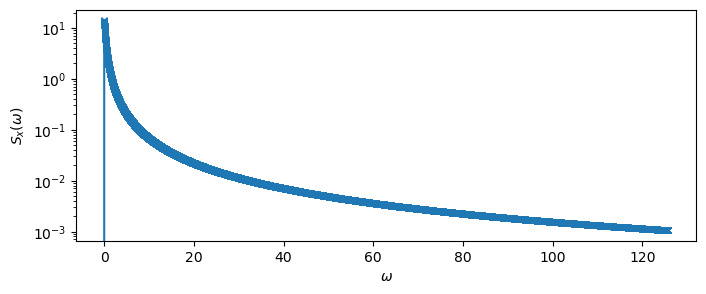

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

T=1800
dt=0.05

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing
print('domega is ' + str(domega))

omega = np.arange(0,N,1)*domega # Frequency axis

# Parameters
A=10.0
I=0.1
z=30.0
U=30.0

omegaz=omega*z/(2*np.pi*U)

# Define spectrum
S=(I*U)**2*A*omegaz/(omega*(1+1.5*A*omegaz)**(5/3))
S[0]=0

# Plot spectrum
plt.figure(figsize=(8,3))
plt.plot(omega,S,marker='x',markersize=5)
plt.ylabel(r'$S_x(\omega)$')
plt.xlabel(r'$\omega$')
plt.yscale('log')

The cosine-sum method is as follows:

$$x(t) = \sum_{k=0}^{N-1}  A_k \cos (\omega_kt + \phi_k) $$

$$A_k = \sqrt{2 S_x(\omega_k) \Delta \omega} $$

Here, $S_x(\omega_k)$ is the auto-spectral density of the process, and $\phi_k$ is random phase angles evenly distributed between $0$ and $2\pi$.

Spent time = 11020.074844360352


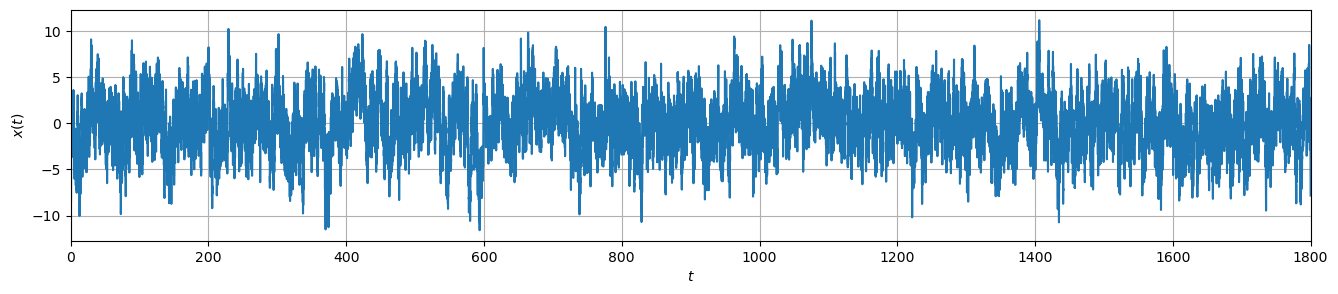

In [2]:
phi = np.random.rand(N)*2*np.pi # Random phase angles 

x = np.zeros_like(t) # Initialize the vector of x values

t0=time.time()
for k in range(N):
    Ak = (2*S[k]*domega)**0.5 #Amplitude
    x = x + Ak * np.cos(omega[k]*t+phi[k]) # Sum the contribution from each harmonic component
t1=time.time()

print('Spent time = ' + str((t1-t0)*1000))

# Plot wind turbulence
plt.figure(figsize=(16,3))
plt.plot(t,x)
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()


The variance is calculated in the time domain from the time series and in the frequency domain as $\sigma^2=\int_{-\infty}^{\infty} S(\omega) \: \text{d}\omega$. These should give the same result.

In [3]:
sd_td=np.std(x) # SD from time series 
sd_fd=np.trapz(S,omega)**0.5 # SD from spectrum

print('Time domain standard deviation is ' + str(sd_td))
print('Frequency domain standard deviation is ' + str(sd_fd))


Time domain standard deviation is 2.9629662890660757
Frequency domain standard deviation is 2.96220683590699


**c)**

We start by attempting to double the length of the time vector: $ t \in [0,\: 2 T]$, and repeat the simulation by the cosine sum method.

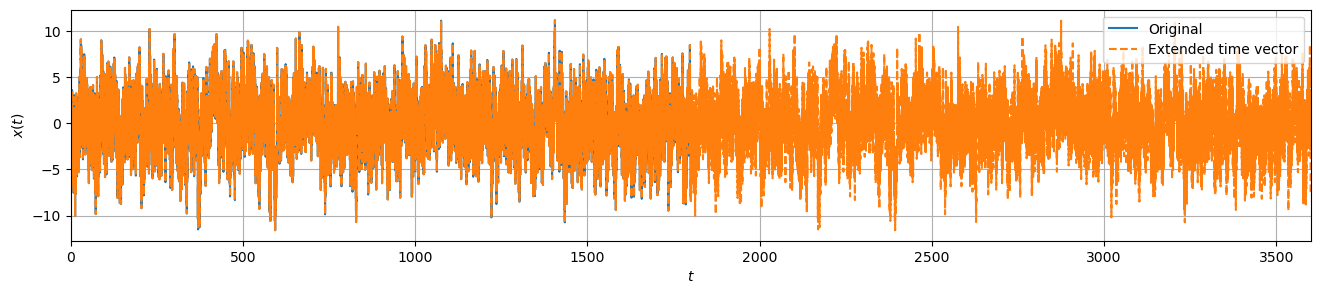

In [4]:
t_double=np.arange(0,2*N,1)*dt # Time axis (double length)

x_double = np.zeros_like(t_double) # Initialize the vector of x values

for k in range(N):
    Ak = (2*S[k]*domega)**0.5 #Amplitude
    x_double = x_double + Ak * np.cos(omega[k]*t_double+phi[k]) # Sum the contribution from each harmonic component

plt.figure(figsize=(16,3))
plt.plot(t,x,label='Original')
plt.plot(t_double,x_double,'--',label='Extended time vector')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,2*T)
plt.legend()
plt.grid()


Upon closer inspection, we observe that the time series from 1800–3600 s (i.e., $T$ to $2T$) is an exact replica of the time series from 0–1800 s ($0$ to $T$). This repetition is a fundamental property of the Fourier series, where we implicitly assume that the time series is periodic with a period $T$. By doubling the length of the time vector without adjusting $\Delta \omega$, the time series simply repeats.

The first cosine wave component, $A_1 \cos (\Delta \omega t)$, will determine the feasible length of the simulation since $\Delta \omega $ is the lowest frequency (the one that takes the longest time to complete one cycle). This argument is the basis for the relationship $T = \dfrac{2 \pi}{\Delta \omega}$.

Doubling the time vector in this way is problematic because it introduces a non-zero auto correlation between the values at times $t$ and $t + T$. As a result, the extended time series no longer has the correct statistical properties, which will affect the statistical results of the calculated dynamic response.

This problem can, however, be solved by simply halving $\Delta \omega$ such that the time vector indeed becomes 1 hour long.




**d)**

The IFFT method is defined as:

$$x(t) = \Re \left(\text{IFFT} \left( A_k e^{i \phi_k} \right) \right)$$



Spent time = 3.9899349212646484


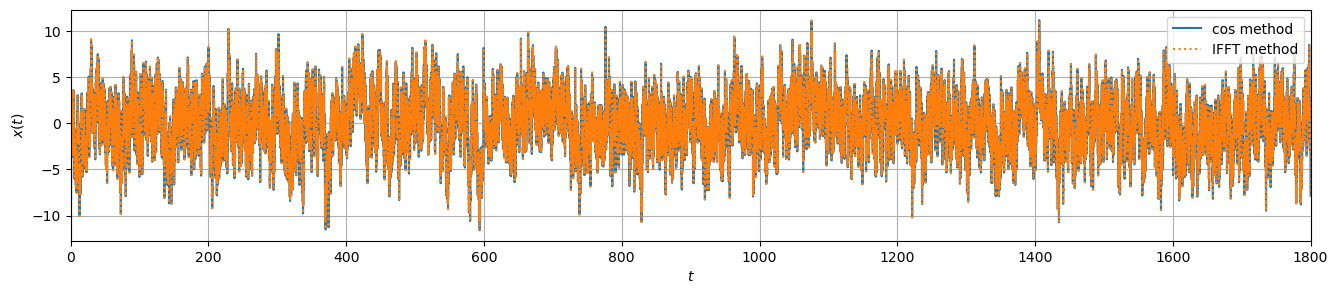

In [5]:
#phi = np.random.rand(N)*2*np.pi # Random phase angles 

t_ifft = np.arange(0,N,1)*dt # Time axis

t0=time.time()
c = (2*S*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x_ifft = np.real(np.fft.ifft(c)*N) # The IFFT
t1=time.time()

print('Spent time = ' + str((t1-t0)*1000))

plt.figure(figsize=(16,3))
plt.plot(t,x,label= 'cos method')
plt.plot(t_ifft,x_ifft,label = 'IFFT method',linestyle=':')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()
plt.legend()

The results are identical to those obtained using the cosine-sum method (when the same phase angles are used). 

However, the IFFT method is significantly faster: approximately 5 ms compared to 15000 ms. This substantial improvement is due to the inherent efficiency of the IFFT algorithm, which reduces computational complexity from $\mathcal{O}(N^2)$ in the cosine-sum approach to $\mathcal{O}(N \log N)$ for the IFFT. For long time series (large $N$), this plays an important role.

Additionally, the way these algorithms are implemented in Python further contributes to the speedup.

### Problem 2: Properties of spectral density

**a)**

The cross-spectral density matrix is defined as:

$$
\mathbf{S}_{\tilde{\mathbf{x}}}(\omega) = \dfrac{1}{2\pi} \int_{-\infty}^{\infty} \mathbf{R}_{\tilde{\mathbf{x}}}(\tau) e^{-i \omega \tau } \:\text{d} \tau
$$


where the cross-correlation matrix is:

$$
\mathbf{R}_{\tilde{\mathbf{x}}}(\tau) = \mathbb{E}[\tilde{\mathbf{x}}(t) \tilde{\mathbf{x}}^\text{T}(t + \tau)]
$$

We can substitute $\tilde{\mathbf{x}}(t) = \mathbf{T} \mathbf{x}(t)$:

$$
\mathbf{R}_{\tilde{\mathbf{x}}}(\tau) = \mathbb{E}[\mathbf{T} \mathbf{x}(t) (\mathbf{T} \mathbf{x}(t + \tau))^\text{T}]
=\mathbf{T} \mathbb{E}[\mathbf{x}(t) \mathbf{x}^\text{T}(t + \tau)] \mathbf{T}^\text{T}
$$

Therefore, the cross-correlation matrix transforms as follows:

$$
\mathbf{R}_{\tilde{\mathbf{x}}}(\tau) = \mathbf{T} \mathbf{R}_{\mathbf{x}}(\tau) \mathbf{T}^\text{T}
$$

Next, we consider the spectral density where $\mathbf{T}$ can be moved outside the integral:

$$
\mathbf{S}_{\tilde{\mathbf{x}}}(\omega) = \dfrac{1}{2\pi} \int_{-\infty}^{\infty} \mathbf{R}_{\tilde{\mathbf{x}}}(\tau) e^{-i \omega \tau}  \:\text{d} \tau
= \dfrac{1}{2\pi} \int_{-\infty}^{\infty} \mathbf{T} \mathbf{R}_{\mathbf{x}}(\tau) \mathbf{T}^\text{T} e^{-i \omega \tau} \:\text{d} \tau
= \dfrac{1}{2\pi} \mathbf{T} \left( \int_{-\infty}^{\infty} \mathbf{R}_{\mathbf{x}}(\tau) e^{-i \omega \tau} \:\text{d} \tau \right) \mathbf{T}^\text{T}
=  \mathbf{T} \mathbf{S}_{\mathbf{x}}(\omega) \mathbf{T}^\text{T}
$$

Such transformation formulas are useful, for instance for a modal transformation.

**b)**

*i)*

$$R_y(\tau)= \text{E}[y(t) y(t + \tau)] $$

We start by differentiating once:

$$
\frac{\text{d} R_y(\tau)}{\text{d} \tau} 
= \mathbb{E} \left[ y(t) \frac{\text{d} y(t + \tau)}{\text{d} \tau} \right]
= \mathbb{E} \left[ y(t) \frac{\text{d} y(t + \tau)}{\text{d} (t+\tau)}\frac{\text{d} (t + \tau)}{\text{d} \tau} \right]
= \mathbb{E} \left[ y(t) \dot{y}(t + \tau) \right]
$$

In the last term, we now have the cross-correlation between the displacement and velocity. In general, if we take the reverse cross-correlation, the function is mirrored: $ R_{x_2 x_2}(\tau)=R_{x_1 x_2}(-\tau)$. We can therefore say:

$$
\mathbb{E} \left[ y(t) \dot{y}(t + \tau) \right]
=
-\mathbb{E} \left[ \dot{y}(t) y(t + \tau) \right]
$$

We can differentiate once more and get:

$$
- \mathbb{E} \left[  \dot{y}(t) \frac{\text{d} y(t + \tau)}{\text{d} \tau} \right]
=
-\mathbb{E} \left[ \dot{y}(t) \frac{\text{d} y(t + \tau)}{\text{d} (t+\tau)}\frac{\text{d} (t + \tau)}{\text{d} \tau} \right]
=
-\mathbb{E} \left[ \dot{y}(t) \dot{y}(t+\tau) \right]
$$

We recognize this as the negative auto correlation of the velocity, $-R_{\dot{y}}(\tau)$.

*ii)*

The auto correlation is the inverse Fourier transform of the spectral density:

$$
R_y(\tau) =  \int_{-\infty}^{\infty} S_y(\omega) e^{i \omega \tau } \:\text{d} \tau
$$

We can use the result from *i)*. If we differentiate twice wrt. to $\tau$ and multiply by -1:
$$
R_{\dot{y}}(\tau)=
-\frac{\text{d}^2 R_y(\tau)}{\text{d} \tau^2}  = 
- \int_{-\infty}^{\infty} (i \omega)^2 S_y(\omega) e^{i \omega \tau } \:\text{d} \tau =
 \int_{-\infty}^{\infty} \omega ^2 S_y(\omega) e^{i \omega \tau } \:\text{d} \tau = 
 \int_{-\infty}^{\infty} S_{\dot{y}}(\omega) e^{i \omega \tau } \:\text{d} \tau
$$

We see that $S_{\dot{y}}(\omega)$ must be $\omega ^2 S_y(\omega)$. By the same argument, the spectral density of the acceleration must be
$$ 
S_{\ddot{y}}(\omega)=\omega^4 S_y(\omega)
$$

This is convenient, as the spectral density of process derivatives (velocity, acceleration) can very easily be obtained from the displacement spectrum.


**c)**

White noise is a theoretical spectral density which contains all frequencies (flat spectrum):

$$
S(\omega) 
= \left\{ \begin{array} a \frac{1}{2}  \sigma_x^2 /\omega_{lim} & \quad 
-\omega_{lim} \leq \omega \leq \omega_{lim}
\\ 0 & \quad \text{elsewhere} \end{array} \right.
$$

In the ideal case, the upper limit $\omega_{lim} \rightarrow \infty$, resulting in true white noise. However, in practice, we more often consider cases where the spectrum is flat and bounded, approximating white noise by a rectangular spectrum.

The expected value is zero.

The autocorrelation is $R_x(\tau)=\sigma_x^2 \delta(\tau)$, where $\delta(\tau)$ is the Dirac delta function, implying that white noise is uncorrelated at different time instants.

The probability density function (PDF) of white noise follows a normal distribution: $\mathcal{N}(0,\sigma_x^2)$.


### Problem 3: Impulse response method and frequency response method

TBU

**a)** 

**b)** 

**c)**

**d)** 

**e)** 